# Key papers

**TOPICS OF INTEREST** - from the meeting in January

* inflammation aging chronic (2004) - 13k papers
* genome editing / manipulation, CRISPR - 13k papers
* induced stem cells - 73k papers - 3h for calculating co-citations
* single-cell sequencing (2012) - 3k papers
* ATAC-seq (2015) - 276 papers
* immunomodulation cancer - 71k papers
* Telomere Theories of Aging - ??
* mTOR pathway - 14255
* autophagy - ??
* Calorie restriction - 3933

Complement Factor H + Age-Related Mascular Degeneration - investigate

A file with citation stats is required to run several cells of this notebook successfully.
The file can be obtained with the following commands if user has access to `pubmed` database (use crawler).

1. Run `psql`.
2. Run following commands in the `psql` prompt:
    * `\f ','`
    * `\a`
    * `\t`
    * `\o '/path/to/the/file'`
    * `SELECT C.pmid_cited AS pmid, P.year, COUNT(1) AS count`
    * `FROM Citations C`
    * `JOIN Publications P`
    * `ON C.pmid_citing = P.pmid`
    * `GROUP BY C.pmid_cited, P.year;`
    * `\o`
3. Store `/path/to/the/file` in the `CITATION_STATS_FILE` variable in the following cell.

**Issues**:

1. Some information in tooltips with long titles may occur out of plot bounds.
2. How should I place articles with the same year? (currently y-axis position is random in [0,1]...)
3. Some research on clustering algorithms is needed! (also `networkx.algorithms.community`)

**Functions**:

1. Subtopic Analysis based on co-citation graph clustering
2. Top Cited Papers detection (overall and for certain year)
3. Citation Dynamics for a certain article

## Search Terms

In [1]:
SEARCH_TERMS = ['human', 'aging', 'epigenetic']

In [2]:
from importlib import reload
import logging
reload(logging)

import gc
import ipywidgets as widgets
import networkx as nx
import numpy as np
import pandas as pd
import psycopg2 as pg_driver

from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, LabelSet, OpenURL, TapTool, CustomJS
from bokeh.plotting import figure, show, output_notebook
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

from Bio import Entrez

Entrez.email = 'nikolay.kapralov@gmail.com'
PUBMED_ARTICLE_BASE_URL = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
output_notebook()

Loading BokehJS ...

2019-05-01 21:39:45,576 DEBUG: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
class KeyPaperAnalyzer:       
    def __init__(self):
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def load_publications(self):
        logging.info('Loading publication data')
        
        query = '''
        SELECT pmid, title, year
        FROM Publications
        WHERE pmid = ANY(%s);
        '''
        
        with self.conn:
            self.cursor.execute(query, (self.pmids,))
        pub_data = []
        for row in self.cursor:
            pub_data.append(list(row))
        self.pub_df = pd.DataFrame(pub_data, columns=['pmid', 'title', 'year'])
        logging.info(f'Found {len(self.pub_df)} publications in the local database')
            
    def load_cocitations(self):
        logging.info('Calculating co-citations for selected articles')

        query = '''
        SELECT C1.pmid_citing, C1.pmid_cited, C2.pmid_cited, P.year
        FROM Citations C1
        JOIN Citations C2
        ON C1.pmid_citing = C2.pmid_citing AND C1.pmid_cited < C2.pmid_cited
        JOIN Publications P
        ON C1.pmid_citing = P.pmid
        WHERE C1.pmid_cited = ANY(%s) AND C2.pmid_cited = ANY(%s)
        LIMIT 10000;
        '''
        print("TODO: Remove LIMIT 10000")

        with self.conn:
            self.cursor.execute(query, (self.pmids, self.pmids,))
            
        cocit_data = []
        for row in self.cursor:
            cocit_data.append(list(row))
        self.cocit_df = pd.DataFrame(cocit_data, columns=['citing', 'cited_1', 'cited_2', 'year'])
        logging.info(f'Found {len(self.cocit_df)} co-cited pairs of articles')
        
        self.cocit_grouped_df = self.cocit_df.groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                          columns=['year'], values=['citing']).reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.replace(np.nan, 0)
        self.cocit_grouped_df['total'] = self.cocit_grouped_df.iloc[:, 2:].sum(axis=1)
        self.cocit_grouped_df = self.cocit_grouped_df.sort_values(by='total', ascending=False)
        
        self.CG = nx.Graph()
        for el in analyzer.cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
            self.CG.add_edge(el[0], el[1], weight=el[2])

    def load_citation_stats(self, cit_stats_file):        
        logging.info('Started loading citation stats')
        self.cit_df = pd.read_csv(cit_stats_file, names=['pmid', 'year', 'count']).fillna(0)
        logging.info('Done loading citation stats')

        # XXX Using set here improves performance drastically!
        pmids_set = set(self.pmids)
        self.cit_df = self.cit_df.loc[np.logical_and([i in pmids_set for i in self.cit_df['pmid']], 
                                                     self.cit_df['year'] > 0)]
        logging.info('Done filtering')

        self.cit_df[['pmid']] = self.cit_df[['pmid']].applymap(np.uint32)
        self.cit_df[['year', 'count']] = self.cit_df[['year', 'count']].applymap(np.uint16)
        logging.info('Done transformation')

        self.cit_df = self.cit_df.pivot(index='pmid', columns='year', values='count').reset_index().replace(np.nan, 0)
        self.cit_df['total'] = self.cit_df.iloc[:, 1:].sum(axis = 1)
        self.cit_df = self.cit_df.sort_values(by='total', ascending=False)
        logging.info('Done aggregation')
        
        logging.info(f"Loaded citation stats for {len(self.cit_df)} of {len(self.pmids)} articles. " +
                    "Others may either have zero citations or be absent in the local database.")

            
    def plot_total_citations(self):
        plt.figure(figsize=(10, 5))
        ax = self.cit_df['total'].plot.bar()
        ax.set_xticklabels([])
        ax.set_xlabel('Articles')
        ax.set_ylabel('Number of citations')
    
    def search(self, *terms):
        print('TODO: handle queries which return more than 100000 items')
        print('TODO: use local database instead of PubMed API')
        self.terms = [t.lower() for t in terms]
        query=' '.join(terms)
        handle = Entrez.esearch(db='pubmed', retmax='100000', retmode='xml', term=query)
        self.pmids = [int(pmid) for pmid in Entrez.read(handle)['IdList']]
        logging.info(f'Found {len(self.pmids)} articles about {terms}')       
        
    def top_cited_papers(self, threshold=0.05):
        ids = self.cit_df.iloc[:round(len(self.cit_df) * threshold), 0].values
        counts = self.cit_df.iloc[:round(len(self.cit_df) * threshold), -1].values
        urls = [PUBMED_ARTICLE_BASE_URL + str(i) for i in ids]
        return zip(ids, urls, counts)

In [4]:
def build_data_source(df):
    # TODO: use d = ColumnDataSource(df)
    d = ColumnDataSource(data=dict(pmid=df['pmid'], title=df['title'], year=df['year'], total=df['total'],
                                   size=np.log(df['total']) / 10, pos=np.random.random(size=len(df))))
    return d

In [5]:
TOOLS = "hover,pan,tap,wheel_zoom,box_zoom,reset,save"

def serve_scatter_article_layout(source, title, year_range=None):
    callback = CustomJS(args=dict(source=source, base=PUBMED_ARTICLE_BASE_URL), code="""
        var data = source.data, selected = source.selected.indices;
        if (selected.length == 1) {
            // only consider case where one glyph is selected by user
            selected_id = data['pmid'][selected[0]]
            for (var i = 0; i < data['pmid'].length; ++i){
                if(data['pmid'][i] == selected_id){
                    window.open(base + data['pmid'][i], '_blank');
                }
            }
        }
    """)

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=400, x_range=year_range, title=title)
    p.xaxis.axis_label = 'Year'
    p.hover.tooltips = [
        ("PMID", '@pmid'),
        ("Title", '@title'),
        ("Year", '@year'),
        ("Cited by", '@total paper(s) total')
    ]
    p.js_on_event('tap', callback)

    p.circle(x='year', y='pos', fill_alpha=0.2, source=source, radius='size')
    
    return p

def serve_citation_dynamics_layout():
    def update(b):
        try:
            pmid = int(text.value)
            data = analyzer.cit_df[analyzer.cit_df['pmid'] == pmid]
            if len(data) == 1:
                x = data.columns[1:-1].values.astype(int)
                y = data[x].values[0]
                bar.data_source.data = {'x': x, 'y': y}
            else:
                text.value = 'Bad ID'
            push_notebook(handle=h)
        except ValueError:
            text.value = ''

    title = "Number of Citations per Year"

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height = 300, title=title)
    p.xaxis.axis_label = "Year"
    p.yaxis.axis_label = "Number of citations"
    p.hover.tooltips = [
        ("Year", "@x"),
        ("Cited by", "@y paper(s) in @x"),
    ]

    d = ColumnDataSource(data=dict(x=[], y=[]))
    bar = p.vbar(x='x', width=0.8, top='y', source=d, color='#A6CEE3', line_width=3)
    
    text = widgets.Text(
        value='',
        placeholder='Enter PMID',
        description='PMID:',
        disabled=False
    )

    button = widgets.Button(
        description='Show',
        disabled=False,
        button_style='info',
        tooltip='Show'
    )
    button.on_click(update)

    panel = widgets.HBox([text, button])

    display(panel)
    h = show(p, notebook_handle=True)
    
    return p, h, panel

In [6]:
from collections import Counter

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

nltk.download('stopwords')

NUM_MOST_COMMON = 5

def get_ngrams(string):
    stop_words = set(stopwords.words('english')) 
    tokens = list(filter(lambda s: any(c.isalpha() for c in s), string.lower().replace(',', '').replace('.', '').split(' ')))
    tokens = [t for t in tokens if t not in stop_words and t not in analyzer.terms]
    ngrams = list(tokens)
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        ngrams.append(t1 + ' ' + t2)
    for t1, t2, t3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        ngrams.append(t1 + ' ' + t2 + ' ' + t3)
    return ngrams

def get_most_common_ngrams(titles):
    ngrams = []
    for title in titles:
        ngrams.extend(get_ngrams(title))
    most_common = {}
    for ngram, cnt in Counter(ngrams).most_common(NUM_MOST_COMMON):
        most_common[ngram] = cnt / len(titles)
    return most_common

[nltk_data] Downloading package stopwords to /Users/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
analyzer = KeyPaperAnalyzer()
analyzer.search(*SEARCH_TERMS)
analyzer.load_publications()
analyzer.pub_df.head()

TODO: handle queries which return more than 100000 items
TODO: use local database instead of PubMed API


2019-05-01 21:39:48,392 INFO: Found 1116 articles about ('human', 'aging', 'epigenetics')
2019-05-01 21:39:48,393 INFO: Loading publication data
2019-05-01 21:39:48,674 INFO: Found 1108 publications in the local database


,pmid,title,year
0,11568897,Methylation and colorectal cancer.,2001
1,11924925,Telomeres and telomerase in human health and d...,2002
2,12154398,DNA methylation and cancer.,2002
3,12163708,Diabetes: a candidate disease for efficient DN...,2002
4,12379901,"Microglia as neuroprotective, immunocompetent ...",2002


In [8]:
# In case this command is too long, you can stop and start DB
# pg_ctl -D /usr/local/var/postgres stop -s -m fast
# pg_ctl -D /usr/local/var/postgres -l /usr/local/var/postgres/server.log start
analyzer.load_cocitations()
analyzer.cocit_df.head()

2019-05-01 21:39:48,725 INFO: Calculating co-citations for selected articles


TODO: Remove LIMIT 10000


2019-05-01 21:48:36,776 INFO: Found 10000 co-cited pairs of articles


,citing,cited_1,cited_2,year
0,24150812,20034555,22037496,2013
1,24150811,19680444,22037496,2013
2,24150811,19680444,22689993,2013
3,24150811,19680444,23828890,2013
4,24150811,22037496,22689993,2013


In [9]:
analyzer.load_citation_stats(cit_stats_file='../citations_per_year.csv')
analyzer.cit_df.head()

2019-05-01 21:48:37,031 INFO: Started loading citation stats
2019-05-01 21:49:20,990 INFO: Done loading citation stats
2019-05-01 21:49:40,065 INFO: Done filtering
2019-05-01 21:49:40,812 INFO: Done transformation
2019-05-01 21:49:40,849 INFO: Done aggregation
2019-05-01 21:49:40,850 INFO: Loaded citation stats for 894 of 1116 articles. Others may either have zero citations or be absent in the local database.


year,pmid,1995,1996,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
535,26799652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,169.0,419.0,397.0,6.0,991.0
238,23828890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,97.0,123.0,115.0,101.0,83.0,0.0,534.0
47,19680444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,48.0,39.0,56.0,60.0,32.0,41.0,25.0,0.0,358.0
498,26451490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,57.0,123.0,109.0,1.0,290.0
121,22037496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,50.0,44.0,43.0,49.0,41.0,30.0,0.0,283.0


In [10]:
df_all = pd.merge(analyzer.pub_df, analyzer.cit_df, on='pmid')
df_all.head()

,pmid,title,year,1995,1996,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
0,11568897,Methylation and colorectal cancer.,2001,0.0,0.0,1.0,2.0,3.0,2.0,1.0,...,1.0,1.0,4.0,3.0,2.0,3.0,2.0,1.0,0.0,37.0
1,11924925,Telomeres and telomerase in human health and d...,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,12154398,DNA methylation and cancer.,2002,0.0,0.0,0.0,2.0,2.0,4.0,0.0,...,9.0,7.0,7.0,7.0,12.0,6.0,3.0,5.0,0.0,84.0
3,12163708,Diabetes: a candidate disease for efficient DN...,2002,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,3.0,3.0,2.0,4.0,2.0,2.0,2.0,3.0,0.0,28.0
4,12379901,"Microglia as neuroprotective, immunocompetent ...",2002,0.0,0.0,0.0,2.0,5.0,6.0,7.0,...,15.0,27.0,16.0,20.0,17.0,14.0,19.0,19.0,1.0,241.0


## Subtopics a.k.a. Clusters in the Co-citation Graph

In [20]:
import community

p = community.best_partition(analyzer.CG)
# q = list(greedy_modularity_communities(analyzer.CG))

2019-05-01 23:05:11,914 DEBUG: update_title_pos
2019-05-01 23:05:12,023 DEBUG: update_title_pos
2019-05-01 23:05:12,101 DEBUG: update_title_pos
2019-05-01 23:05:12,143 DEBUG: update_title_pos


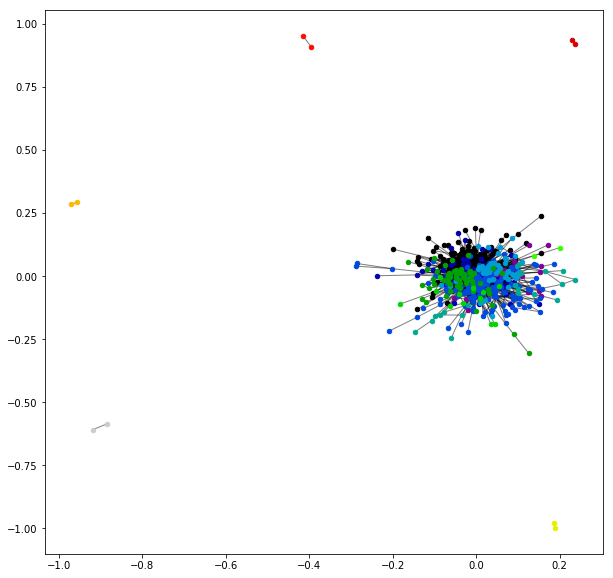

In [38]:
import networkx as nx

# Visualize components
plt.figure(figsize=(10, 10))
components = list(set(p.values())) 
size = float(len(components))
pos = nx.spring_layout(analyzer.CG)
cmap = plt.cm.get_cmap('nipy_spectral', len(set(p.values())))
for i, com in enumerate(components):
    list_nodes = [nodes for nodes in p.keys() if p[nodes] == com]
    nx.draw_networkx_nodes(analyzer.CG, pos, list_nodes, node_size = 20, node_color = [cmap(i)])

nx.draw_networkx_edges(analyzer.CG, pos, alpha=0.5)
plt.show()

In [34]:
df_comp = pd.Series(p).reset_index().rename(columns={'index': 'pmid', 0: 'comp'})
df_all = pd.merge(df_all, df_comp, on='pmid')
df_all.head()

,pmid,title,year,1995,1996,2002,2003,2004,2005,2006,...,2013,2014,2015,2016,2017,2018,2019,total,comp_x,comp_y
0,26799652,Guidelines for the use and interpretation of a...,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,169.0,419.0,397.0,6.0,991.0,3,3
1,23828890,Global epigenomic reconfiguration during mamma...,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,97.0,123.0,115.0,101.0,83.0,0.0,534.0,0,0
2,19680444,Aging and environmental exposures alter tissue...,2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,56.0,60.0,32.0,41.0,25.0,0.0,358.0,2,2
3,26451490,Comprehensive Molecular Portraits of Invasive ...,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,57.0,123.0,109.0,1.0,290.0,3,5
4,22037496,5-hmC-mediated epigenetic dynamics during post...,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,44.0,43.0,49.0,41.0,30.0,0.0,283.0,0,0


In [13]:
years = df_all.columns.values[3:-2].astype(int)
min_year, max_year = np.min(years), np.max(years)

In [14]:
n_comps = df_all['comp'].nunique()
ds = [None] * n_comps
layouts = [None] * n_comps
most_common = [None] * n_comps
for c in range(n_comps):
    ds[c] = build_data_source(df_all[df_all['comp'] == c])
    most_common[c] = dict(get_most_common_ngrams(df_all[df_all['comp'] == c]['title'].values))
    kwd = ', '.join([f'{k} ({v:.2f})' for k, v in most_common[c].items()])
    title = f'Subtopic #{c + 1}: {kwd}'
    layouts[c] = serve_scatter_article_layout(ds[c], title, year_range=[min_year, max_year])
    show(layouts[c])

## Top Cited Papers Overall

In [15]:
df_all = df_all.sort_values(by='total', ascending=False)

In [16]:
THRESHOLD = 0.1 # 10 %

In [17]:
ds_top = build_data_source(df_all.iloc[:round(len(analyzer.cit_df) * THRESHOLD), :])
layout_top = serve_scatter_article_layout(ds_top, 'Top cited papers', year_range=[min_year, max_year])
show(layout_top)

## Top Cited Papers for Each Year

In [18]:
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap

max_gain_data = []
cols = df_all.columns[3:-2]
for i in range(len(cols)):
    max_gain = df_all[cols[i]].astype(int).max()
    if max_gain > 0:
        sel = df_all[df_all[cols[i]] == max_gain]
        max_gain_data.append([cols[i], sel['pmid'].values[0], 
                              sel['title'].values[0], max_gain])
        
max_gain_df = pd.DataFrame(max_gain_data, columns=['year', 'pmid', 'title', 'count'])
max_gain_df.head(20)

ds_max = ColumnDataSource(data=dict(year=max_gain_df['year'], pmid=max_gain_df['pmid'].astype(str),
                                   title=max_gain_df['title'], count=max_gain_df['count']))
colors = factor_cmap('pmid', palette=Category10[10], factors=max_gain_df['pmid'].astype(str).unique())

year_range = [1985, 2019]
p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=300, x_range=year_range, title='Max gain')
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Number of citations'
p.hover.tooltips = [
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@year'),
    ("Cited by", '@count papers in @year')
]

p.vbar(x='year', width=0.8, top='count', fill_alpha=0.2, source=ds_max, fill_color=colors, line_color=colors)

show(p)

## Citation per Year Dynamics

In [19]:
p, h, panel = serve_citation_dynamics_layout()